In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from util import *

In [3]:
columns = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

Omega = np.load("../genai/scenarios.npy")
df = pd.DataFrame(Omega[0], columns=columns)



In [ ]:

print(df.columns)
fixed_window = pd.read_csv('../genai/fixed_window.csv', index_col=0)
print(fixed_window.columns)
fixed_window.columns = columns
print(fixed_window.columns)
df = pd.concat([fixed_window, df])
print(df.columns)
try:
    
    df['T2M'] = (df["T2M_MIN"] + df["T2M_MAX"])/2 
    print(df.columns)
    df.rename(columns={"ALLSKY_SFC_SW_DWN":"RS", "CLRSKY_SFC_SW_DWN": "RSO",
                "PRECTOTCORR": "PRECIPITATION"}, inplace=True)
    # CLRSKY_SFC_SW_DWN?
    df['RSO'] = df['RS']
    print(df.columns)
    # Merge with real data and fix scenario generation according tactical planning  
    df_season = df#.loc['2022-11-01':'2023-04-29'].copy()
    if len(df_season) < 180:
        print(f"Warning: Season data is short ({len(df_season)} days). Using available data.")
    else:
        df_season = df_season.iloc[:180]
    print(f"Loaded {len(df_season)} days of weather data for simulation.")
except FileNotFoundError:
    print("="*50)
    print("ERROR: Data file not found. Please re-run Cell 4 to download the data.")
    print("="*50)

Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M', 'T2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECIPITATION', 'RS', 'RH2M', 'WS2M', 'T2M',
       'RSO'],
      dtype='object')
Loaded 180 days of weather data for simulation.


In [5]:
df_season.reset_index(inplace=True)


In [6]:
# ==============================================
# 2.0) OLIVE CROP PARAMETERS
# ==============================================
print("Olive parameters loaded.")
print(f"  Yield Coeff (CCh): {CCh}")
print(f"  Thermal Time (Tsum): {Tsum} GDD")
print(f"  Soil TAW (Max): {critical_water} mm")
print(f"  Soil RAW (Trigger): {critical_depletion} mm")


Olive parameters loaded.
  Yield Coeff (CCh): 0.0405
  Thermal Time (Tsum): 2000 GDD
  Soil TAW (Max): 160 mm
  Soil RAW (Trigger): 80 mm


In [7]:
# --- Pre-calculate all environmental factors ---
df_season['FTemp'] = fTemp(Tbase, Topt, df_season['T2M'])
df_season['FHeat'] = fHeat(Theat, Textreme, df_season['T2M_MAX'])
df_season['FSolar'] = fSolar(fSolarmax, I50A, I50B, Tsum, Tbase, df_season['T2M'])
ETO_series, ETC_series = RN(alfa, df_season['RS'], df_season['RSO'], SIGMA,
                             df_season['T2M_MIN'], df_season['T2M_MAX'],
                             df_season['RH2M'], df_season['T2M'],
                             Altitude, n, E, Cp, G, df_season['WS2M'])
df_season['ETO'] = ETO_series
df_season['ETC'] = ETC_series

# Potential biomass accumulation factor
df_season['EF_t'] = df_season['RS'] * df_season['FSolar'] * df_season['FTemp'] * SCO2

print("Environmental factors pre-calculated.")


Environmental factors pre-calculated.


C:\Users\fperezg\AppData\Local\Temp\ipykernel_20744\1867912525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['FTemp'] = fTemp(Tbase, Topt, df_season['T2M'])
C:\Users\fperezg\AppData\Local\Temp\ipykernel_20744\1867912525.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['FHeat'] = fHeat(Theat, Textreme, df_season['T2M_MAX'])
C:\Users\fperezg\AppData\Local\Temp\ipykernel_20744\1867912525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [ ]:
print("SIMPLE model function defined.")

SIMPLE model function defined.


In [ ]:
print("Running 'Rainfed' scenario...")
df_rainfed = run_simple_model(df_season, 'rainfed')

print("Running 'Optimized' scenario...")
df_optimized = run_simple_model(df_season, 'optimized')

print("Simulations complete.")

Running 'Rainfed' scenario...
Running 'Optimized' scenario...
Simulations complete.


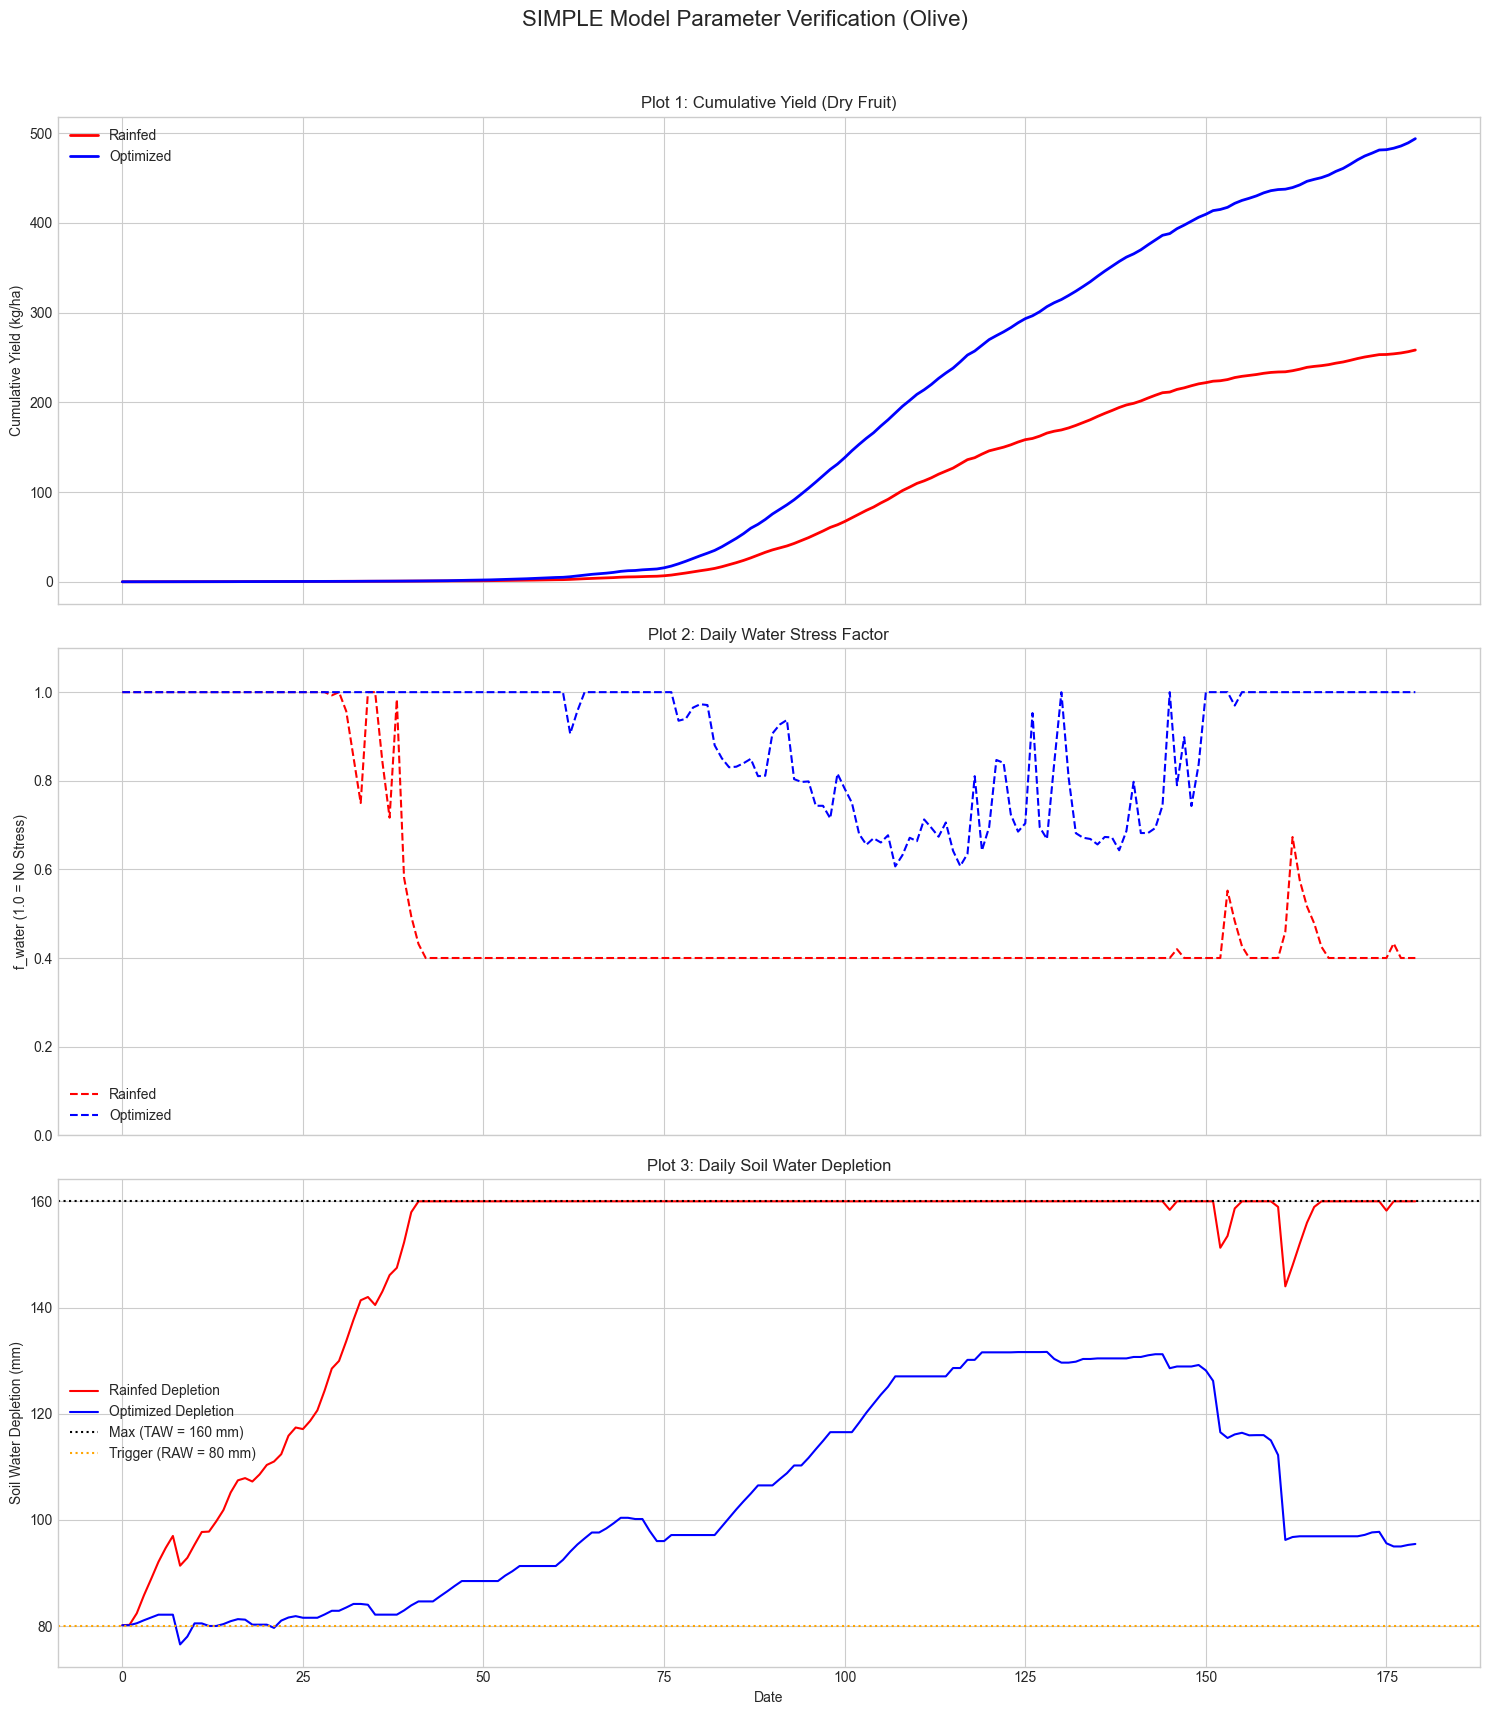


FINAL SIMULATION SUMMARY
--- Rainfed Scenario ---
  Total Yield:       258 kg/ha (Dry Fruit)
  Total Water (Rain): 76 mm
  Avg. f_water:      0.53

--- Optimized Scenario ---
  Total Yield:       494 kg/ha (Dry Fruit)
  Total Water (Rain): 76 mm
  Total Irrigation:  784 mm
  Avg. f_water:      0.90



In [ ]:

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle('SIMPLE Model Parameter Verification (Olive)', fontsize=16)

# --- Plot 1: Cumulative Yield ---
ax1.plot(df_rainfed.index, df_rainfed['Cumulative_Yield_kgHa'],
         label='Rainfed', color='red', linewidth=2)
ax1.plot(df_optimized.index, df_optimized['Cumulative_Yield_kgHa'],
         label='Optimized', color='blue', linewidth=2)
ax1.set_ylabel('Cumulative Yield (kg/ha)')
ax1.set_title('Plot 1: Cumulative Yield (Dry Fruit)')
ax1.legend()

# --- Plot 2: Water Stress (f_water) ---
ax2.plot(df_rainfed.index, df_rainfed['f_water'],
         label='Rainfed', color='red', linestyle='--')
ax2.plot(df_optimized.index, df_optimized['f_water'],
         label='Optimized', color='blue', linestyle='--')
ax2.set_ylabel('f_water (1.0 = No Stress)')
ax2.set_title('Plot 2: Daily Water Stress Factor')
ax2.set_ylim(0, 1.1)
ax2.legend()

# --- Plot 3: Soil Water Depletion ---
ax3.plot(df_rainfed.index, df_rainfed['Depletion_mm'],
         label='Rainfed Depletion', color='red')
ax3.plot(df_optimized.index, df_optimized['Depletion_mm'],
         label='Optimized Depletion', color='blue')

# Plot the TAW and RAW thresholds
ax3.axhline(y=critical_water, color='black', linestyle=':',
            label=f'Max (TAW = {critical_water} mm)')
ax3.axhline(y=critical_depletion, color='orange', linestyle=':',
            label=f'Trigger (RAW = {critical_depletion} mm)')

ax3.set_ylabel('Soil Water Depletion (mm)')
ax3.set_title('Plot 3: Daily Soil Water Depletion')
ax3.set_xlabel('Date')
ax3.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


print("\n" + "="*50)
print("FINAL SIMULATION SUMMARY")
print("="*50)

# Rainfed Results
final_yield_rf = df_rainfed['Cumulative_Yield_kgHa'].iloc[-1]
total_precip = df_season['PRECIPITATION'].sum()

# Optimized Results
final_yield_opt = df_optimized['Cumulative_Yield_kgHa'].iloc[-1]
total_irrigation_opt = df_optimized['Irrigation_mm'].sum()

print(f"--- Rainfed Scenario ---")
print(f"  Total Yield:       {final_yield_rf:.0f} kg/ha (Dry Fruit)")
print(f"  Total Water (Rain): {total_precip:.0f} mm")
print(f"  Avg. f_water:      {df_rainfed['f_water'].mean():.2f}\n")

print(f"--- Optimized Scenario ---")
print(f"  Total Yield:       {final_yield_opt:.0f} kg/ha (Dry Fruit)")
print(f"  Total Water (Rain): {total_precip:.0f} mm")
print(f"  Total Irrigation:  {total_irrigation_opt:.0f} mm")
print(f"  Avg. f_water:      {df_optimized['f_water'].mean():.2f}\n")

print("="*50)